# **导入相关包**

In [1]:
import os
import pandas as pd
import torch
import torchvision.transforms as transforms
from PIL import Image
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch.nn.functional as F

# **设置超参数**

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'  # 选择设备

valid_ratio = 0.2  # 验证集比例
learning_rate = 1e-4
epoches = 5
batch_size = 256

# **数据集**

In [3]:
cats_train_dir = '../data/Cat vs Dog/train/cats'    # cats训练集根目录
dogs_train_dir = '../data/Cat vs Dog/train/dogs'    # dogs训练集根目录
test_dir = '../data/Cat vs Dog/test'     # 测试集根目录

cats_train_filenames = [os.path.join(cats_train_dir, f) for f in os.listdir(cats_train_dir)]  # 每个cat图文件地址合并为list
dogs_train_filenames = [os.path.join(dogs_train_dir, f) for f in os.listdir(dogs_train_dir)]  # 每个dog图文件地址合并为list
cats_train_filenames

['../data/Cat vs Dog/train/cats\\cat.0.jpg',
 '../data/Cat vs Dog/train/cats\\cat.1.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10.jpg',
 '../data/Cat vs Dog/train/cats\\cat.100.jpg',
 '../data/Cat vs Dog/train/cats\\cat.1000.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10000.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10001.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10002.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10003.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10004.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10005.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10006.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10007.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10008.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10009.jpg',
 '../data/Cat vs Dog/train/cats\\cat.1001.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10010.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10011.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10012.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10013.jpg',
 '../data/Cat vs Dog/train/cats\\ca

In [4]:
# 把cats和dogs统一归为训练集
train_filenames = [*cats_train_filenames, *dogs_train_filenames]
# 训练集文件地址
test_filenames = [os.path.join(test_dir, f) for f in os.listdir(test_dir)]
train_filenames

['../data/Cat vs Dog/train/cats\\cat.0.jpg',
 '../data/Cat vs Dog/train/cats\\cat.1.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10.jpg',
 '../data/Cat vs Dog/train/cats\\cat.100.jpg',
 '../data/Cat vs Dog/train/cats\\cat.1000.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10000.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10001.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10002.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10003.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10004.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10005.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10006.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10007.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10008.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10009.jpg',
 '../data/Cat vs Dog/train/cats\\cat.1001.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10010.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10011.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10012.jpg',
 '../data/Cat vs Dog/train/cats\\cat.10013.jpg',
 '../data/Cat vs Dog/train/cats\\ca

## **数据增强**

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize(223),
    transforms.CenterCrop(223),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.490, 0.482, 0.445], std=[0.240, 0.237, 0.257])
])

test_transforms = transforms.Compose([
    transforms.Resize(223),
    transforms.CenterCrop(223),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.490, 0.482, 0.445], std=[0.240, 0.237, 0.257])
])

## **定义数据集** 

In [6]:
class DogandCat(Dataset):
    def __init__(self, filenames, transforms):
        self.filenames = filenames
        self.transforms = transforms

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img = Image.open(self.filenames[idx])
        transformed_img = self.transforms(img)
        label = 0 if self.filenames[idx].split('\\')[-1].split('.')[0] == 'cat' else 1  # dog的标签为1,cat的标签为0
        return transformed_img, label

## **划分数据集** 

In [7]:
num_filename = len(train_filenames)
num_train = int(num_filename * (1 - valid_ratio))

train_dataset = DogandCat(train_filenames[:num_train], train_transforms)
valid_dataset = DogandCat(train_filenames[num_train:], test_transforms)
test_dataset = DogandCat(test_filenames, test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# **神经网络**

In [8]:
class MyAlexNet(nn.Module):
    def __init__(self):
        super(MyAlexNet, self).__init__()
        self.c1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2)
        self.ReLU = nn.ReLU()
        self.s1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.c2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
        self.s2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.c3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.c4 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
        self.c5 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.s3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.f6 = nn.Linear(9216, 4096)
        self.f7 = nn.Linear(4096, 4096)
        self.f8 = nn.Linear(4096, 1000)
        self.f9 = nn.Linear(1000, 2)

    def forward(self, x):
        x = self.ReLU(self.c1(x))
        x = self.s1(x)
        x = self.ReLU(self.c2(x))
        x = self.s2(x)
        x = self.ReLU(self.c3(x))
        x = self.ReLU(self.c4(x))
        x = self.ReLU(self.c5(x))
        x = self.s3(x)
        x = self.flatten(x)
        x = self.f6(x)
        x = F.dropout(x, p=0.5)
        x = self.f7(x)
        x = F.dropout(x, p=0.5)
        x = self.f8(x)
        x = F.dropout(x, p=0.5)
        x = self.f9(x)

        return x

model = MyAlexNet().to(device)

In [9]:
# 定义损失器,优化器
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# **数据可视化**

In [10]:
# 中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def matplot_loss(train_loss, val_loss):
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.legend(loc='best')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('训练集与验证集Loss值对比图')
    plt.show()

In [11]:
def matplot_acc(train_acc, val_acc):
    plt.plot(train_acc, label='train_acc')
    plt.plot(val_acc, label='val_acc')
    plt.legend(loc='best')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.title('训练集与验证集Acc值对比图')
    plt.show()

In [12]:
loss_train = []
acc_train = []
loss_val = []
acc_val = []

# **模型训练**

training on -----------------
Epoch:1


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:08<00:00,  1.15it/s]


train loss: 0.6063
train acc: 0.6754


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.40it/s]


epoch1:save the best model
valid loss: 1.2373
valid acc: 0.2704
----------------------------------------
Epoch:2


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:03<00:00,  1.24it/s]


train loss: 0.5285
train acc: 0.7406


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.40it/s]


epoch2:save the best model
valid loss: 0.5051
valid acc: 0.7344
----------------------------------------
Epoch:3


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:03<00:00,  1.24it/s]


train loss: 0.4469
train acc: 0.7924


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.38it/s]


valid loss: 0.7664
valid acc: 0.6278
----------------------------------------
Epoch:4


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:04<00:00,  1.23it/s]


train loss: 0.3850
train acc: 0.8282


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.42it/s]


valid loss: 0.6836
valid acc: 0.6824
----------------------------------------
Epoch:5


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:03<00:00,  1.24it/s]


train loss: 0.3190
train acc: 0.8637


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.40it/s]


epoch5:save the best model
valid loss: 0.4562
valid acc: 0.7854
----------------------------------------


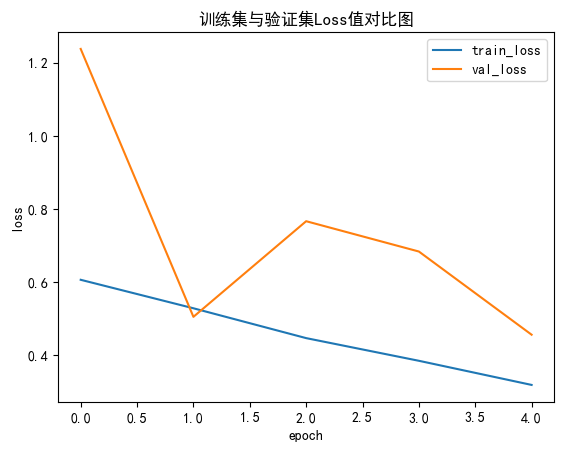

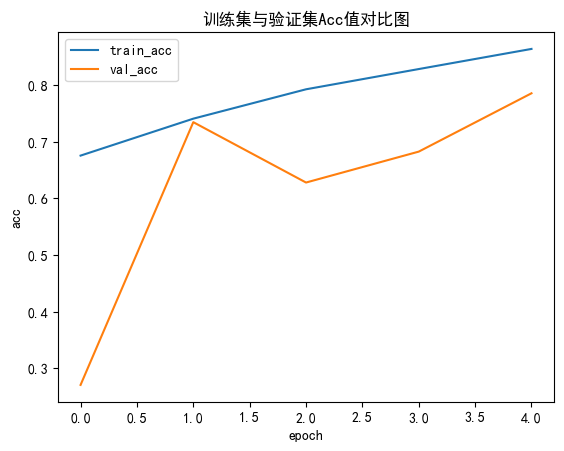

In [13]:
min_acc = 0  # 为保存最佳valid_acc的网络参数文件
print('training on -----------------')
for epoch in range(epoches):
    print(f'Epoch:{epoch + 1}')
    epoch_loss, epoch_corrects = 0.0, 0.0
    model.train()
    for img, label in tqdm(train_loader):
        img, label = img.to(device), label.to(device)
        label_hat = model(img)
        pred = torch.argmax(label_hat, 1)
        loss = criterion(label_hat, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * img.size(0)
        epoch_corrects += torch.sum(pred == label.data)
    epoch_loss = epoch_loss / len(train_loader.dataset)
    epoch_acc = epoch_corrects / len(train_loader.dataset)
    loss_train.append(epoch_loss)
    acc_train.append(epoch_acc.cpu().numpy())

    print(f"train loss: {epoch_loss:.4f}")
    print(f"train acc: {epoch_acc:.4f}")

    val_loss, val_corrects = 0.0, 0.0
    model.eval()
    with torch.no_grad():
        for img, label in tqdm(valid_loader):
            img, label = img.to(device), label.to(device)
            label_hat = model(img)
            pred = torch.argmax(label_hat, 1)
            loss = criterion(label_hat, label)

            val_loss += loss.item() * img.size(0)
            val_corrects += torch.sum(pred == label.data)
    val_loss = val_loss / len(valid_loader.dataset)
    val_acc = val_corrects / len(valid_loader.dataset)

    loss_val.append(val_loss)
    acc_val.append(val_acc.cpu().numpy())
    # 保存最佳模型
    if val_acc > min_acc:
        folder = '../save_model'
        if not os.path.exists(folder):
            os.makedirs(os.path.join(folder))
        min_acc = val_acc
        print(f'epoch{epoch+1}:save the best model')
        torch.save(model.state_dict(), '../save_model/best_model.pth')
    if epoch == epoches - 1:
        torch.save(model.state_dict(), '../save_model/last_model.pth')

    print(f"valid loss: {val_loss:.4f}")
    print(f"valid acc: {val_acc:.4f}")
    print("-" * 40)

# 可视化
matplot_loss(loss_train, loss_val)
matplot_acc(acc_train, acc_val)

# **保存csv**

In [14]:
sample = pd.read_csv('../data/Cat vs Dog/sample_submission.csv')
result = []
# 加载训练最好的pth文件参数
model.load_state_dict(torch.load('../save_model/best_model.pth'))

with torch.no_grad():
    model.eval()
    for img, label in tqdm(test_loader):
        img, label = img.to(device), label.to(device)

        label_hat = model(img)
        pred = torch.argmax(label_hat, 1)
        result.extend(pred.cpu().numpy())

sample['labels'] = result
sample.to_csv('../data/Cat vs Dog/predict.csv', index=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:24<00:00,  1.30it/s]


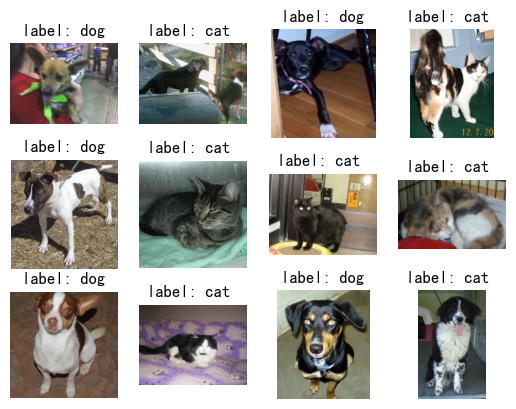

In [15]:
# 查看结果
for i in range(12):
    plt.subplot(3, 4,i+1)
    image = plt.imread(os.path.join(test_filenames[i]))
    plt.imshow(image)
    plt.axis("off")
    title = "cat " if int(result[i]) == 0 else 'dog'
    plt.title(f"label: {title}")